# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [276]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

from scipy.fft import dct

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

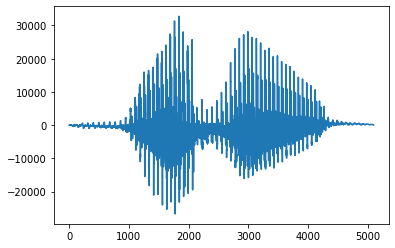

In [277]:
from scipy.io import wavfile

file_path = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

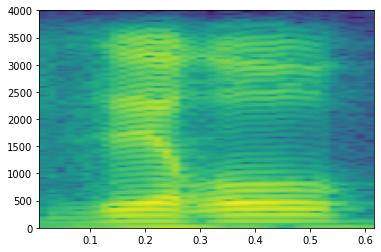

In [278]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

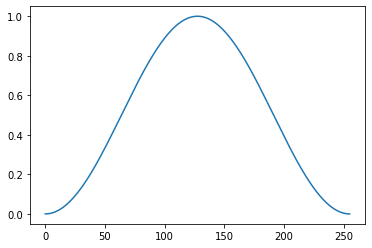

In [279]:
plt.plot(np.hanning(256))
plt.show()

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [280]:
def parse(wav_data, window_size = 256, window_shift = 128):
    """
    This function parses the audio signal in frames of smaller duration with some overlap.
    The overlap is used because the Hamming window makes unusable the border values of the frames, with overlapping they are not null in every frame.
    :param wav_data: The numpy array representing the signal
    :param window_size: The number of element per frames (256)
    :param window_shift: The overlapping frames (by default : 128)
    :return: A numpy array with one element being one frame of the signal
    """   
   
    frame_overlap = window_size - window_shift
    frame_number = wav_data.size // frame_overlap
    return np.array([wav_data[i*frame_overlap:(i+1)*frame_overlap+window_shift ] for i in range(frame_number-1)], dtype=np.float64) # each frame is still 1 frame wide
                                                                                                                
    

In [281]:
def feature_extraction(wav_data, window_size = 256, window_shift = 128, cepstral_order = 10):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    
        
    sliced_signal = parse(wav_data, window_size, window_shift)
    hanning_window = np.hanning(window_size)
    
    for elem in sliced_signal:
        elem *=  hanning_window
         
    fft_norm_vector = np.square(np.absolute(np.fft.fft(sliced_signal)))       
    
    signal_log = np.log(1+fft_norm_vector)   
    
  
    cepstral_vectors = np.array(dct(signal_log,type=2, axis=1, norm='ortho'))[:,1:cepstral_order+1]    #We don't keep the first mfcc because it represents the signal amplitude  
    
    assert (cepstral_vectors.shape[1] == cepstral_order)
    
    
    return cepstral_vectors

In [282]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [283]:
def plot_cepstral_coefs(cepstral_vectors):
    """
    This function prints into matplotlib the graph of audio file's cepstral coefficients.
        """
    fig, ax = plt.subplots(figsize=(10, 6))
    cepstral_vectors= np.swapaxes(cepstral_vectors, 0 ,1)
    cax = ax.imshow(cepstral_vectors, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    ax.set_title('Cepstral Coefficients')
    plt.xlabel('Frame', fontsize=20)
    plt.ylabel('Cepstral Coefficients', fontsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()
    

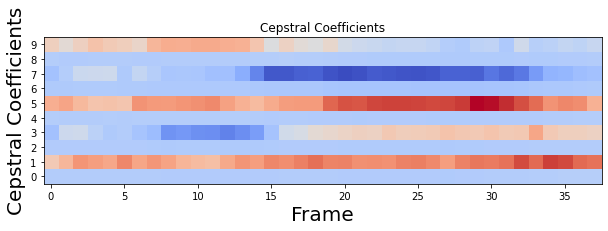

In [284]:
plot_cepstral_coefs(cepstral_vectors)

In [285]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $D (l_X \times l_Y)$ such that $D(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $C (l_X \times l_Y)$ such that $C(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $C(i,i)$ then $C(i+1,i), \dots C(l_X,i)$ and $C(i,i+1), C(i,i+2), \dots C(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```C```).

In [286]:
def min_box(pred, pred_weight, C, D, i, j, gamma):
    """
    Picks the minimum from the square box formed by the point (i,j) and above, right and diagonal.
    Stores the (i,j) coordinates into an array in the box of the min by side effect.
    
    :param pred: The array which stores predecessors
    :param dtw_matrix: The matrix with the values   
    :param i: The abscissa of the point    
    :param j: The ordinate of the point    
    """
    
    v1 = C[i-1, j]
    v2 = C[i, j-1]
    v3 = C[i-1, j-1] 
    
    cost = D[i,j]
    
    weights = [v1+cost, v2+cost, v3 + gamma * cost]
    indexes = [(i-1,j), (i, j-1), (i-1, j-1)]
    opti_weight = min(weights)
    idx = indexes[np.argmin(weights)]
    
    pred[i,j] = idx
    pred_weight[i,j]= gamma if idx ==(i-1,j-1) else 1
    
    return pred, pred_weight, opti_weight

In [287]:
def path_length(pred, pred_weight, n, m):
    """
    Calculates the length of a path.
    Recursively goes through the predessors till reaching coordinates (0, 0).
        
    :param pred: array storing the predecessors
    :param n: abscissa of the point in the bottom right corner of the cumdist matrix
    :param m: ordinate of the point in the bottom right corner of the cumdist matrix
    :return: path's length
    """
    length = 0
    v = (n,m)
    
    while v[0] != 0 or v[1]!= 0:
        length += pred_weight[v[0],v[1]]
        v = pred[v[0],v[1]]
    
    return length

In [288]:
def alignement_path(pred, length, n, m):

    M = np.zeros(length, dtype='2i')
    v = (n,m)
    for i in range(1,length):
        M[length-i] = v
        v = pred[v[0],v[1]]  
    M[0] = v
    
    return M
    

In [289]:
from scipy.spatial.distance import cdist

def time_alignment(x, y, gamma):
    
    
    n, m = len(x), len(y)
    
    # array to remember path
    pred = np.zeros((n, m), dtype='2i')
    pred_weight = np.zeros((n, m), dtype=int)
    
    # compute the similarity (distance) matrix
    D = cdist(x.reshape(-1, 1), y.reshape(-1, 1))
    
    # initialize the cumulative distance matrix
    C = np.zeros((n, m))
    
    # calculate the content of the 1st row and 1st column of the cumdist matrix
    C[0, 0] = D[0, 0]
    
    # case j=0: predecessor can only be one line below
    for i in range(1,n):
        C[i, 0] = C[i-1, 0] + D[i, 0]
        pred[i,0] = (i-1, 0)
        pred_weight[i,0] = 1
    
    # case i=0: predecessor can only be one column to the left
    for j in range(1,m):
        C[0, j] = C[0, j-1] + D[0, j]
        pred[0,j] = (0, j-1)
        pred_weight[0,j] = 1
        
    # complete the cumdist matrix
    for i in range(1,n):
        for j in range(1,m):
            C[i, j] = np.inf
            
    for i in range(1, n):
        for j in range(1, m):
            pred, pred_weight, last_min = min_box(pred, pred_weight, C, D, i, j, gamma)
            C[i, j] = last_min
    
    # compute the cumulative distance along the path of least cost
    length = path_length(pred, pred_weight, n-1, m-1)
    M = alignement_path(pred, length, n-1, m-1)
    
    return C, M, C[n-1,m-1], length


In [290]:
# Example of time alignment
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./Data/SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
C, M, distance, length = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

In [302]:
def print_path(M,dtw_matrix, distance):
    """
    This function prints the path of the DWT algorithm in a 2D graph.
    :param pred: The array which stores predecessors
    :param n: The abscissa of the point in the upper right corner of the graph
    :param m: The ordinate of the point in the upper right corner of the graph
    """
    
    n,m = M[-1]

    fig, ax = plt.subplots(figsize=(15,5))    
    dtw_matrix= np.swapaxes(dtw_matrix, 0 ,1)
    cax = ax.imshow(dtw_matrix, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    plt.plot(M[:,0], M[:,1],'r',linewidth=2)
        
    plt.show()

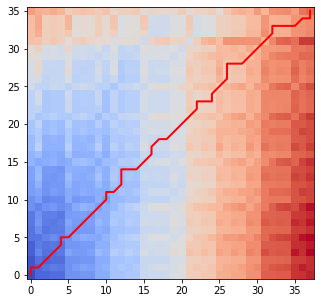

In [303]:
print_path(M, C, distance/length)

## Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [304]:
#Loading the audio files

file_path = "./Data/SIG/"
filename = "SIG_Rep_1_Number_1.wav"
idx = 8
word1 = np.zeros(12, dtype=object)
n = word1.size
for i in range(1,n+1):
    file = filename[:idx] + str(i) + filename[idx + 1:]
    word1[i-1] =  wavfile.read(file_path+file)[1]

    print(file + " loaded.")

ref = word1[0]

SIG_Rep_1_Number_1.wav loaded.
SIG_Rep_2_Number_1.wav loaded.
SIG_Rep_3_Number_1.wav loaded.
SIG_Rep_4_Number_1.wav loaded.
SIG_Rep_5_Number_1.wav loaded.
SIG_Rep_6_Number_1.wav loaded.
SIG_Rep_7_Number_1.wav loaded.
SIG_Rep_8_Number_1.wav loaded.
SIG_Rep_9_Number_1.wav loaded.
SIG_Rep_10_Number_1.wav loaded.
SIG_Rep_11_Number_1.wav loaded.
SIG_Rep_12_Number_1.wav loaded.


In [305]:
#Computing the cepstral coefficients 

cc_ref = feature_extraction(ref)

cc_word1 = np.zeros(n, dtype = object)
for i in range(n):
    cc_word1[i] = feature_extraction(word1[i])

In [308]:
dtw_word1 = np.zeros(n)

for i in range(n):
    _, _, distance, length = time_alignment(cc_ref, cc_word1[i], gamma=2)
    dtw_word1[i] = distance/length


dtw_min = float('inf')
for i in range(n):
        if(dtw_word1[i]< dtw_min):
            dtw_min = dtw_word1[i]
            sample = i
            
print(dtw_word1)
            
print(f"Corresponding index of audio file :", sample)

[0.     3.1821 3.1893 3.5204 3.4305 3.213  2.7058 2.2671 2.2365 2.8415
 4.619  3.4638]
Corresponding index of audio file : 0


## Evaluation of Speech Recognition

The goal of this part is to implement different cross-validation strategies in order to evaluate how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. We will then rotate the reference/unknown sets to perform cross-validation. 
To do so, write a function ```evaluation_recognition```.

For example, you can use the following formalism : 

```[confusion, accuracy, D] = evaluation_recognition(vectors, gamma, protocol)```

- ```vectors``` contains all the cepstral vectors for the signals in the database. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.
- ```protocol``` is an integer value between 1 and 3 indicating the protocol to be used: each protocol corresponds to a particular way of dividing signals into training and testing sets. 

- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate.
- ```D``` is the distance matrix between each of the elements of the database of size $10N \times 10N$, where $N$ is the number of repetitions. Note that only parts of ```D``` will be used, depending on the protocol choosed. 

The three proposed evaluation protocols are:
- **Protocol 1**: The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the reference set and the remaining subset (1/3 of repetitions) is used for the unknown set. The procedure is repeated by rotating the unknown and reference sets.
- **Protocol 2**: A database containing only one pronunciation of each number is used as a reference database. The remaining repetitions are used for the unkown set. The procedure is repeated by rotating the unkown and reference sets. This protocol aims at evaluating the generalization capabilities of the recognition system. 
- **Protocol 3**: The first half of the database of ```SIG_MIXED``` is used as a reference database and the second half as the unkown database. The procedure is repeated by inversing the role of the two sets. This protocol aims at evaluating the generalization capabilities on a database containing data from the two speakers. Careful: since the goal here is to understand if you can use examples from one person to recognize numbers pronounced by a different person, you have to not shuffle the examples !

Questions: 
- Evaluate the speech recognition performance with protocol 1 on the data ```SIG```, and then on the data ```SIG2```. What are the confusions ? What value of $\gamma$ parameter offers the best results ?
- Evaluate the generalization capabilities using protocol 2 on the data ```SIG```, and then on the data ```SIG2```. What do you notice?
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Explain the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose possible solutions to these problems.